<a href="https://colab.research.google.com/github/Esteves31/Neural_Networks/blob/main/Projeto01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 1 - Supervisionado

---

## Classificação e Regressão

  <div style="text-align: justify; font-size: 15px;">
  Neste projeto serão apresentados dois dois datasets: íris e {...}, com o objetivo de relizar uma classificação e uma regressão. Serão considerados alguns pontos como a utilização de diferentes número de camadas, o impacto do uso do Momentum, avaliação do impacto do uso da regularização e a ilustração gráfica da evolução do treinamento/validação.
  </div>


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary

## Importação da Base de Dados

In [ ]:
dataBase = sklearn.datasets.load_iris()
print("Atributos:",dataBase['feature_names'])
print("Classes (labels):",dataBase['target_names'])
print("Dimensões:", dataBase['data'].shape)

df = pd.DataFrame(dataBase.data, columns = dataBase.feature_names)
df['label'] = [dataBase.target_names[i] for i in dataBase.target]

Atributos: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes (labels): ['setosa' 'versicolor' 'virginica']
Dimensões: (150, 4)


## Processamento dos dados

In [ ]:
X = df.drop(['label'], axis = 1)
normalizer = MinMaxScaler()
X_norm = pd.DataFrame(normalizer.fit_transform(X), columns = X.columns)
labels = df.label.unique()
print(labels, end = "\n\n")

Y = pd.get_dummies(df.label)
print(Y)

['setosa' 'versicolor' 'virginica']

     setosa  versicolor  virginica
0         1           0          0
1         1           0          0
2         1           0          0
3         1           0          0
4         1           0          0
..      ...         ...        ...
145       0           0          1
146       0           0          1
147       0           0          1
148       0           0          1
149       0           0          1

[150 rows x 3 columns]


## Separação para Treino / Validação / Teste

In [ ]:
X_develop, X_test, Y_develop, Y_test = train_test_split(X_norm, Y, test_size = 0.1, random_state = 1)

X_train, X_val, Y_train, Y_val = train_test_split(X_develop, Y_develop, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(108, 4)
(27, 4)
(15, 4)


## Modelo 1

### Modelo de Treino

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.rede = nn.Sequential(
        nn.Linear(input_dim, 10),
        nn.Tanh(),
        nn.Linear(10, output_dim),
        nn.Sigmoid(),
    )

  def forward(self, x):
    out =  self.rede(x)
    return out

### Instanciando o Modelo

In [ ]:
input_dim = 4
output_dim = 3

model = MLP(input_dim, output_dim)

print(model, end = "\n\n")
summary(model, (150,4))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 150, 10]              50
              Tanh-2              [-1, 150, 10]               0
            Linear-3               [-1, 150, 3]              33
           Sigmoid-4               [-1, 150, 3]               0
Total params: 83
Trainable params: 83
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### Otimizador e Função de Custo

In [ ]:
eta = 0.2
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = eta)

### Treinamento da Rede

### Transformação dos Dados em Tensores Pytorch

In [ ]:
x_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(Y_train.values)

x_val = torch.FloatTensor(X_val.values)
y_val = torch.FloatTensor(Y_val.values)

x_test = torch.FloatTensor(X_val.values)
y_test = torch.FloatTensor(Y_val.values)

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Laço de Treinamento

In [ ]:
def train_network(model, optimizer, loss_function, x_train, y_train, x_val, y_val, num_epochs, train_losses, val_lossess):
  for epoch in range(num_epochs):
    optimizer.zero_grad()

    output_train = model(x_train)

    loss_train = loss_function(output_train, y_train)

    loss_train.backward()

    optimizer.step()

    output_val = model(x_val)
    loss_val = loss_function(output_val, y_val)

    train_losses[epoch] = loss_train.item()
    val_losses[epoch] = loss_val.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs}, Erro de Treino: {loss_train.item():.4f}, Erro de Validação: {loss_val.item():.3f}")


In [ ]:
num_epochs = 5000
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)

train_network(model, optimizer, loss_function, x_train, y_train, x_val, y_val, num_epochs, train_losses, val_losses)

Epoca: 100 / 5000, Erro de Treino: 0.1772, Erro de Validação: 0.184
Epoca: 200 / 5000, Erro de Treino: 0.1444, Erro de Validação: 0.147
Epoca: 300 / 5000, Erro de Treino: 0.1265, Erro de Validação: 0.126
Epoca: 400 / 5000, Erro de Treino: 0.1172, Erro de Validação: 0.115
Epoca: 500 / 5000, Erro de Treino: 0.1114, Erro de Validação: 0.108
Epoca: 600 / 5000, Erro de Treino: 0.1070, Erro de Validação: 0.103
Epoca: 700 / 5000, Erro de Treino: 0.1034, Erro de Validação: 0.099
Epoca: 800 / 5000, Erro de Treino: 0.1001, Erro de Validação: 0.096
Epoca: 900 / 5000, Erro de Treino: 0.0969, Erro de Validação: 0.092
Epoca: 1000 / 5000, Erro de Treino: 0.0937, Erro de Validação: 0.088
Epoca: 1100 / 5000, Erro de Treino: 0.0903, Erro de Validação: 0.085
Epoca: 1200 / 5000, Erro de Treino: 0.0867, Erro de Validação: 0.081
Epoca: 1300 / 5000, Erro de Treino: 0.0829, Erro de Validação: 0.077
Epoca: 1400 / 5000, Erro de Treino: 0.0788, Erro de Validação: 0.073
Epoca: 1500 / 5000, Erro de Treino: 0.0747,

### Resultados

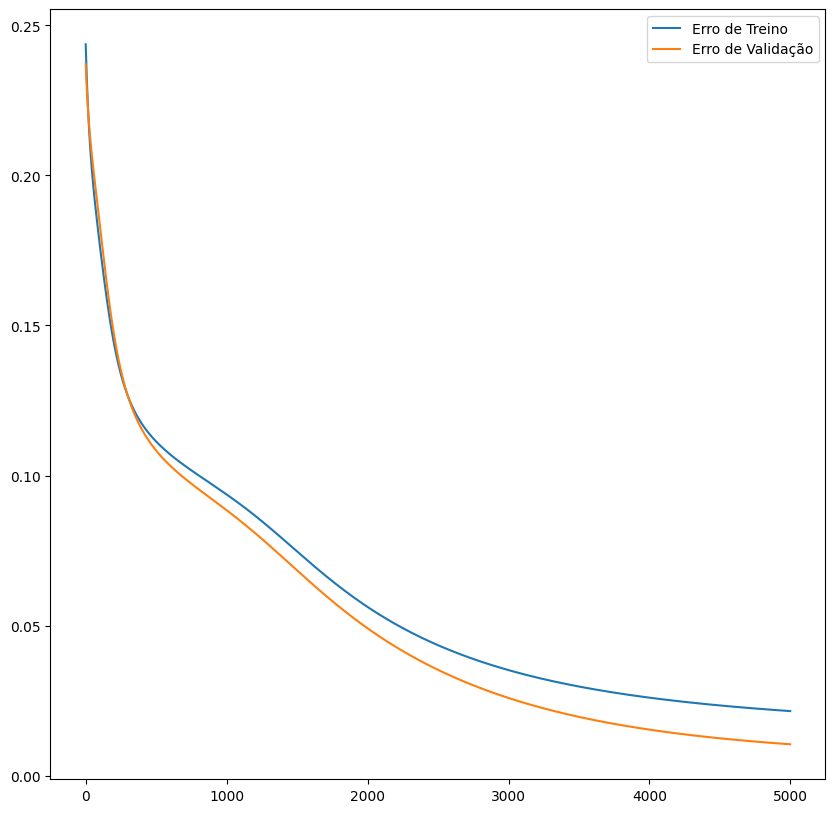

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses, label='Erro de Treino')
plt.plot(val_losses, label='Erro de Validação')
plt.legend()
plt.show()

### Erros de Treino / Validação / Teste

In [ ]:
predictions_train = []
predictions_val = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(x_train)
    predictions_val = model(x_val)
    predictions_test = model(x_test)

error_train = loss_function(predictions_train, y_train)
error_val = loss_function(predictions_val, y_val)
error_test = loss_function(predictions_test, y_test)

print(f"Erro de Treino: {error_train}")
print(f"Erro de Validação: {error_val}")
print(f"Erro de Teste: {error_test}")

Erro de Treino: 0.02150990068912506
Erro de Validação: 0.010456599295139313
Erro de Teste: 0.010456599295139313


### Acurácia da Classificação

In [ ]:
pred_train = torch.argmax(predictions_train, dim=1)
label_train = torch.argmax(y_train, dim=1)
pred_val = torch.argmax(predictions_val, dim=1)
label_val = torch.argmax(y_val, dim=1)
pred_test = torch.argmax(predictions_test, dim=1)
label_test = torch.argmax(y_test, dim=1)

from sklearn.metrics import accuracy_score
acc_train = accuracy_score(label_train, pred_train)
acc_val = accuracy_score(label_val, pred_val)
acc_test = accuracy_score(label_test, pred_test)


print(f"Acurácia de Treino: {acc_train*100:.2f}%")
print(f"Acurácia de Validação: {acc_val*100:.2f}%")
print(f"Acurácia de Teste: {acc_test*100:.2f}%")

Acurácia de Treino: 96.30%
Acurácia de Validação: 100.00%
Acurácia de Teste: 100.00%


## Modelo 2

### Modelo de treino

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.rede = nn.Linear(input_size, output_size)

  def forward(self, x):
    out = self.rede(x)
    return out

### Instanciando o modelo

In [ ]:
input_size = 4
output_size = 3

model2 = MLP(input_size, output_size)

print(model2, end = "\n\n")
summary(model2, (150,4))

MLP(
  (rede): Linear(in_features=4, out_features=3, bias=True)
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 150, 3]              15
Total params: 15
Trainable params: 15
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


### Otimizador e Função de Custo

In [ ]:
eta = 0.2
loss_function2 = nn.MSELoss()
optmizer2 = torch.optim.SGD(model.parameters(), lr = eta)

### Treinamento da Rede

### Transformação dos Dados em Tensores PyTorch